<a href="https://colab.research.google.com/github/Jgallear/CSSP_brazil_23_24/blob/main/drought_alert_forecasts_caatinga_multiclass_RFC_MO_SPEI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
!pip install rioxarray
!pip install cartopy
!pip install rasterio
#!pip install alibi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 103.5 MB/s eta 0:00:00


In [ ]:
#!pip install anchor-exp

In [ ]:
#from anchor import utils
#from anchor import anchor_tabular

In [ ]:
import rioxarray as riox
from rasterio.enums import Resampling
import xarray as xr
from rasterio import CRS
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping
from shapely.geometry import Point
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import glob
from scipy import stats
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import spearmanr
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_pickle(f_name):
  f = open(f_name,'rb')
  f_obj = pickle.load(f)
  f.close()
  return f_obj

In [ ]:
# load shapefile using geopandas
biom_shp = gpd.read_file('/content/drive/MyDrive/shapefiles/Biomas_250mil/lm_bioma_250.shp')
print(biom_shp)

            Bioma  CD_Bioma                                           geometry
0        Amazônia         1  MULTIPOLYGON (((-44.08515 -2.41669, -44.0856 -...
1        Caatinga         2  POLYGON ((-41.7408 -2.80826, -41.73673 -2.8093...
2         Cerrado         3  POLYGON ((-43.39009 -2.33937, -43.38741 -2.342...
3  Mata Atlântica         4  MULTIPOLYGON (((-48.70814 -28.44851, -48.70994...
4           Pampa         5  POLYGON ((-52.82472 -27.46295, -52.81558 -27.4...
5        Pantanal         6  POLYGON ((-57.75946 -15.72779, -57.75659 -15.7...


In [ ]:
df = load_pickle('/content/drive/MyDrive/rs_data/MO_SPEI/MO_SPEI_df.pkl')
print(df)

         longitude  latitude        VHI  year  month     precip  rtzsm_inst  \
0          -53.375   -33.625  51.021667  2003      2  259.88287   98.905430   
1          -53.375   -33.375  56.413615  2003      2  263.87030   98.808440   
2          -53.125   -33.375  51.933297  2003      2  264.47006   97.968110   
3          -53.125   -33.125  56.654990  2003      2  272.27457   98.378110   
4          -52.875   -33.125  49.726269  2003      2  257.30900   97.940735   
...            ...       ...        ...   ...    ...        ...         ...   
2567138    -60.375     4.875  62.075416  2021     12  150.79850   99.038830   
2567139    -60.125     4.875  63.210981  2021     12  125.50701   93.635956   
2567140    -60.625     5.125  61.006296  2021     12  169.49919   92.256210   
2567141    -60.375     5.125  57.378575  2021     12  188.04920   99.967990   
2567142    -60.125     5.125  58.236603  2021     12  198.82608  100.000000   

           spei1m    spei2m    spei3m  ...   spei12

In [ ]:

amazonia = biom_shp[biom_shp['CD_Bioma'] == 1]
caatinga = biom_shp[biom_shp['CD_Bioma'] == 2]
cerrado = biom_shp[biom_shp['CD_Bioma'] == 3]
atlantica = biom_shp[biom_shp['CD_Bioma'] == 4]
pampa = biom_shp[biom_shp['CD_Bioma'] == 5]
pantanal = biom_shp[biom_shp['CD_Bioma'] == 6]
print(pantanal)


      Bioma  CD_Bioma                                           geometry
5  Pantanal         6  POLYGON ((-57.75946 -15.72779, -57.75659 -15.7...


In [ ]:

def convert_df_to_geodf(df):
  geometry = [Point(ij) for ij in zip(df.longitude,df.latitude)]
  gdf = gpd.GeoDataFrame(df,crs='EPSG:4326',geometry=geometry)
  return gdf


In [ ]:
geodf = convert_df_to_geodf(df)

In [ ]:
amazonia_df = gpd.sjoin(geodf,amazonia,predicate='within')
caatinga_df = gpd.sjoin(geodf,caatinga,predicate='within')
cerrado_df = gpd.sjoin(geodf,cerrado,predicate='within')
atlantica_df = gpd.sjoin(geodf,atlantica,predicate='within')
pampa_df = gpd.sjoin(geodf,pampa,predicate='within')
pantanal_df = gpd.sjoin(geodf,pantanal,predicate='within')
# concatenate dataframes
df_br = pd.concat([amazonia_df,caatinga_df,cerrado_df,atlantica_df,pampa_df,pantanal_df])

/tmp/ipython-input-4235599953.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4674

  amazonia_df = gpd.sjoin(geodf,amazonia,predicate='within')
/tmp/ipython-input-4235599953.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4674

  caatinga_df = gpd.sjoin(geodf,caatinga,predicate='within')
/tmp/ipython-input-4235599953.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4674

  cerrado_df = gpd.sjoin(geodf,cerrado,predicate='within')
/tmp/ipython-input-4235599953.py:4: Use

In [ ]:
#amazonia_df.plot('VHI')
#caatinga_df.plot('VHI')
#cerrado_df.plot('VHI')
#atlantica_df.plot('VHI')
#pampa_df.plot('VHI')
#pantanal_df.plot('VHI')
#

In [ ]:
print(amazonia_df)

         longitude  latitude        VHI  year  month     precip  rtzsm_inst  \
2742       -58.125   -16.375  47.318607  2003      2  172.88004   36.262463   
2819       -60.125   -16.125  48.988169  2003      2  139.04288   43.076800   
2820       -59.875   -16.125  50.091751  2003      2  146.50452   34.778835   
2821       -59.625   -16.125  48.615362  2003      2  173.05340   36.372047   
2822       -59.375   -16.125  49.383378  2003      2  188.18088   52.353860   
...            ...       ...        ...   ...    ...        ...         ...   
2567138    -60.375     4.875  62.075416  2021     12  150.79850   99.038830   
2567139    -60.125     4.875  63.210981  2021     12  125.50701   93.635956   
2567140    -60.625     5.125  61.006296  2021     12  169.49919   92.256210   
2567141    -60.375     5.125  57.378575  2021     12  188.04920   99.967990   
2567142    -60.125     5.125  58.236603  2021     12  198.82608  100.000000   

           spei1m    spei2m    spei3m  ...    spi_0

In [ ]:
# function to remove variables not required
"""
def remove_vars(df):
  df_removed = df.drop(columns=['Bioma','CD_Bioma','geometry','lat','lon','index_right','year','month'])
  return df_removed
"""

"\ndef remove_vars(df):\n  df_removed = df.drop(columns=['Bioma','CD_Bioma','geometry','lat','lon','index_right','year','month'])\n  return df_removed\n"

In [ ]:
"""
amazonia_df_pca = remove_vars(amazonia_df)
caatinga_df_pca = remove_vars(caatinga_df)
cerrado_df_pca = remove_vars(cerrado_df)
atlantica_df_pca = remove_vars(atlantica_df)
pampa_df_pca = remove_vars(pampa_df)
pantanal_df_pca = remove_vars(pantanal_df)

br_bioma = df_br['Bioma']
br_CD_Bioma = df_br['CD_Bioma']
df_br = remove_vars(df_br)
"""


"\namazonia_df_pca = remove_vars(amazonia_df)\ncaatinga_df_pca = remove_vars(caatinga_df)\ncerrado_df_pca = remove_vars(cerrado_df)\natlantica_df_pca = remove_vars(atlantica_df)\npampa_df_pca = remove_vars(pampa_df)\npantanal_df_pca = remove_vars(pantanal_df)\n\nbr_bioma = df_br['Bioma']\nbr_CD_Bioma = df_br['CD_Bioma']\ndf_br = remove_vars(df_br)\n"

In [ ]:
"""
# get standardized versions using standard scaler
def scale_data(df):
  scaler = StandardScaler()
  df_scaled = scaler.fit_transform(df)
  return df

"""

'\n# get standardized versions using standard scaler\ndef scale_data(df):\n  scaler = StandardScaler()\n  df_scaled = scaler.fit_transform(df)\n  return df\n\n'

In [ ]:

"""
amazonia_df_scaled = scale_data(amazonia_df_pca)
caatinga_df_scaled = scale_data(caatinga_df_pca)
cerrado_df_scaled = scale_data(cerrado_df_pca)
atlantica_df_scaled = scale_data(atlantica_df_pca)
pampa_df_scaled = scale_data(pampa_df_pca)
pantanal_df_scaled = scale_data(pantanal_df_pca)
# scale df_br data
df_br_scaled = scale_data(df_br)
"""

'\namazonia_df_scaled = scale_data(amazonia_df_pca)\ncaatinga_df_scaled = scale_data(caatinga_df_pca)\ncerrado_df_scaled = scale_data(cerrado_df_pca)\natlantica_df_scaled = scale_data(atlantica_df_pca)\npampa_df_scaled = scale_data(pampa_df_pca)\npantanal_df_scaled = scale_data(pantanal_df_pca)\n# scale df_br data\ndf_br_scaled = scale_data(df_br)\n'

In [ ]:
#print(amazonia_df_scaled.shape)

In [ ]:
def group_df(df):
  # append grouped dfs into list
  df_list = []
  # group by lat and lon
  df_grouped = df.groupby(['latitude','longitude'])
  # append each group to list
  for group in df_grouped:
    df_list.append(group)
  return df_list

In [ ]:
# create new column in amazonia_df which corresponds to rtzsm_inst value for the next month for each df in df_list
def create_next_month_col(df_list):
  # create new column in each df in df_list which corresponds to rtzsm_inst value for the next month
  for df in df_list:
    df[1]['VHI_next'] = df[1]['VHI'].shift(-1)
  return df_list


In [ ]:
def create_next_month_var(df):
  df_list = group_df(df)
  df_list = create_next_month_col(df_list)
  df_merged = pd.concat([df[1] for df in df_list])
  #df_merged = df_merged.drop(columns=['index'])
  df_merged = df_merged.reset_index(drop=True)
  df_merged = df_merged.dropna()
  return df_merged

In [ ]:
caatinga_df_merged = create_next_month_var(caatinga_df)
cerrado_df_merged = create_next_month_var(cerrado_df)
atlantica_df_merged = create_next_month_var(atlantica_df)
pampa_df_merged = create_next_month_var(pampa_df)
pantanal_df_merged = create_next_month_var(pantanal_df)
amazonia_df_merged = create_next_month_var(amazonia_df)

In [ ]:
# train different GBM and RFR models using bootstrapping to produce uncertainty for Caatinga VHI forecast
def remove_cols(df):
  df_removed = df.drop(columns=['index_right','geometry','Bioma','CD_Bioma','spei1m','spei2m','spei3m','spi_01','spi_02','spi_03','spei6m','spei12m'])
  return df_removed

In [ ]:
def split_df(df):
  # choose random years from dataframe
  train = df[df['year'] < 2018]
  test = df[df['year'] >= 2018]
  return train, test

In [ ]:
caatinga_data = remove_cols(caatinga_df_merged)
caatinga_train, caatinga_test = split_df(caatinga_data)

In [ ]:
pantanal_data = remove_cols(pantanal_df_merged)
pantanal_train, pantanal_test = split_df(pantanal_data)

In [ ]:
amazonia_data = remove_cols(amazonia_df_merged)
amazonia_train, amazonia_test = split_df(amazonia_data)

In [ ]:
cerrado_data = remove_cols(cerrado_df_merged)
cerrado_train, cerrado_test = split_df(cerrado_data)

In [ ]:
RFR_reg = RandomForestRegressor(n_estimators=100,random_state=42)


In [ ]:
# split train and test into x and y
X_train = caatinga_train.drop(columns=['VHI_next'])
y_train = caatinga_train['VHI_next']
x_test = caatinga_test.drop(columns=['VHI_next'])
y_test = caatinga_test['VHI_next']

In [ ]:
# Need to change NN configuration for classification with softmax output
print(X_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(202270, 13)
(202270,)
(53110, 13)
(53110,)


In [ ]:
# Get model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(18,)), # shape of input (i.e. Just number of features)
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2) # output layer shape is the same as the number of classes
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Need to create labels for data by taking thresholds from VHI
# Create labels for train and test data
train_labels = np.where(y_train > 40, 1, 0)
test_labels = np.where(y_test > 40, 1, 0)

In [ ]:
# create labels using multiple thresholds
def create_labels(df):
  labels = np.where(df > 40, 1, 0)
  return labels

In [ ]:
print(train_labels)

[0 0 0 ... 1 1 1]


In [ ]:
# define model as randomforestclassifier
model = RandomForestClassifier(n_estimators=100,random_state=42)

In [ ]:
print(X_train)

        longitude  latitude        VHI  year  month     precip  rtzsm_inst  \
0         -43.625   -16.375  48.847092  2003      2  21.272581   15.995748   
1         -43.625   -16.375  38.437785  2003      3  57.438198   15.065541   
2         -43.625   -16.375  36.187071  2003      4  22.478333   27.119629   
3         -43.625   -16.375  33.244057  2003      5   2.128676   16.330154   
4         -43.625   -16.375  29.727946  2003      6   0.000000   19.214056   
...           ...       ...        ...   ...    ...        ...         ...   
256457    -40.125    -2.875  75.261785  2017      8   0.000000   27.014313   
256458    -40.125    -2.875  70.254602  2017      9   0.000000   12.248808   
256459    -40.125    -2.875  66.815062  2017     10   1.539913   33.085880   
256460    -40.125    -2.875  60.800818  2017     11   0.000000    1.974725   
256461    -40.125    -2.875  59.727618  2017     12  11.568439   31.772526   

          msdwlwrf         t2m       pev  spei_30_days  spei_60

In [ ]:
#model.fit(X_train, train_labels, epochs=10)
model.fit(X_train, train_labels)

RandomForestClassifier(random_state=42)

In [ ]:
#test_loss, test_acc = model.evaluate(x_test,  test_labels, verbose=2)

#print('\nTest accuracy:', test_acc)

In [ ]:
#probability_model = tf.keras.Sequential([model,
#                                         tf.keras.layers.Softmax()])

In [ ]:
predictions = model.predict_proba(x_test)

/tmp/ipython-input-3985972291.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T,


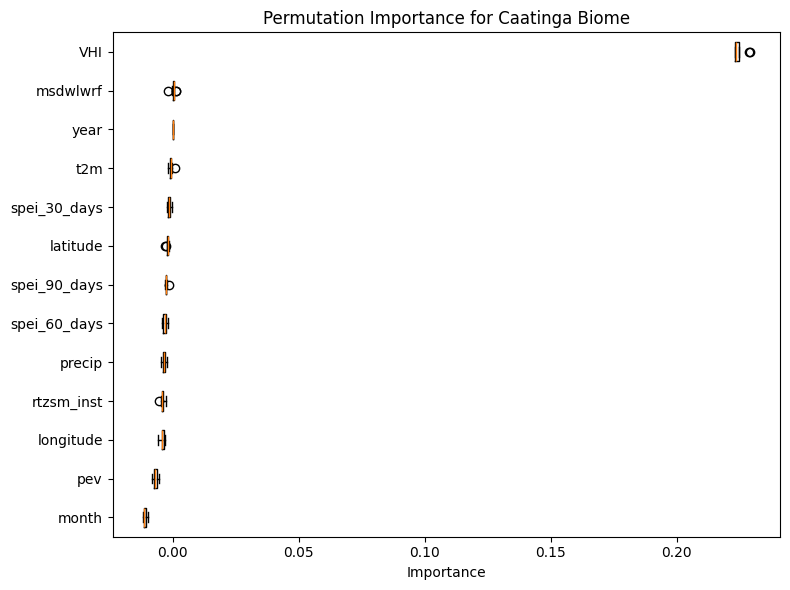

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Calculate permutation importance for the entire test set
result = permutation_importance(model, x_test, test_labels, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

# Plot permutation importance
plt.figure(figsize=(8, 6))
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=x_test.columns[sorted_idx])
plt.title("Permutation Importance for Caatinga Biome")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
# prompt: plot partial dependency for precip
"""
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Select the feature to plot partial dependency for (precip)
feature_index = X_train.columns.get_loc('precip')

# Plot partial dependency
plt.figure(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(model, X_train, [feature_index], feature_names=X_train.columns.tolist())
plt.suptitle("Partial Dependency Plot for Precip in Caatinga Biome")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()
"""

'\nimport matplotlib.pyplot as plt\nfrom sklearn.inspection import PartialDependenceDisplay\n\n# Select the feature to plot partial dependency for (precip)\nfeature_index = X_train.columns.get_loc(\'precip\')\n\n# Plot partial dependency\nplt.figure(figsize=(8, 6))\nPartialDependenceDisplay.from_estimator(model, X_train, [feature_index], feature_names=X_train.columns.tolist())\nplt.suptitle("Partial Dependency Plot for Precip in Caatinga Biome")\nplt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap\nplt.show()\n'

In [ ]:
"""
# Select the feature to plot partial dependency for (precip)
feature_index = X_train.columns.get_loc('t2m')

# Plot partial dependency
plt.figure(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(model, X_train, [feature_index], feature_names=X_train.columns.tolist())
plt.suptitle("Partial Dependency Plot for t2m in Caatinga Biome")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()
"""

'\n# Select the feature to plot partial dependency for (precip)\nfeature_index = X_train.columns.get_loc(\'t2m\')\n\n# Plot partial dependency\nplt.figure(figsize=(8, 6))\nPartialDependenceDisplay.from_estimator(model, X_train, [feature_index], feature_names=X_train.columns.tolist())\nplt.suptitle("Partial Dependency Plot for t2m in Caatinga Biome")\nplt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap\nplt.show()\n'

In [ ]:
predictions[0]

array([0.32, 0.68])

In [ ]:
np.argmax(predictions[0])

np.int64(1)

In [ ]:
test_labels[0]

np.int64(1)

In [ ]:
test_labels[0]

np.int64(1)

In [ ]:
# Need to evaluate predictions against test data
# produce a map of probability of drought for a particular time slice
print(x_test)

        longitude  latitude        VHI  year  month      precip  rtzsm_inst  \
179       -43.625   -16.375  49.550081  2018      1  101.785866    7.856639   
180       -43.625   -16.375  55.758888  2018      2  185.649930   64.927500   
181       -43.625   -16.375  55.967001  2018      3   91.033610   33.082700   
182       -43.625   -16.375  56.261465  2018      4   38.368736    5.066605   
183       -43.625   -16.375  55.017148  2018      5    0.453407    8.241758   
...           ...       ...        ...   ...    ...         ...         ...   
256504    -40.125    -2.875  47.687943  2021      7   14.897347   31.113653   
256505    -40.125    -2.875  55.700974  2021      8    0.000000   40.514210   
256506    -40.125    -2.875  57.413235  2021      9    0.000000   29.374584   
256507    -40.125    -2.875  64.088588  2021     10    0.000000   53.669280   
256508    -40.125    -2.875  60.751643  2021     11    7.135414   88.954250   

          msdwlwrf         t2m       pev  spei_30_d

In [ ]:
# combine x with y and prediction probabilities so that a probability can be associated with a time and location
print(x_test.shape)
print(predictions.shape)
print(y_test.shape)

(53110, 13)
(53110, 2)
(53110,)


In [ ]:
x_data = x_test
x_data['y_test'] = y_test
x_data['predictions_0'] = predictions[:,0]
x_data['predictions_1'] = predictions[:,1]
x_data['test_labels'] = test_labels
print(x_data)

        longitude  latitude        VHI  year  month      precip  rtzsm_inst  \
179       -43.625   -16.375  49.550081  2018      1  101.785866    7.856639   
180       -43.625   -16.375  55.758888  2018      2  185.649930   64.927500   
181       -43.625   -16.375  55.967001  2018      3   91.033610   33.082700   
182       -43.625   -16.375  56.261465  2018      4   38.368736    5.066605   
183       -43.625   -16.375  55.017148  2018      5    0.453407    8.241758   
...           ...       ...        ...   ...    ...         ...         ...   
256504    -40.125    -2.875  47.687943  2021      7   14.897347   31.113653   
256505    -40.125    -2.875  55.700974  2021      8    0.000000   40.514210   
256506    -40.125    -2.875  57.413235  2021      9    0.000000   29.374584   
256507    -40.125    -2.875  64.088588  2021     10    0.000000   53.669280   
256508    -40.125    -2.875  60.751643  2021     11    7.135414   88.954250   

          msdwlwrf         t2m       pev  spei_30_d

In [ ]:
# Need to determine which is 0 and which is 1, then can plot for a given time segment predictions 1
# plot map of predictions_1 for year 2018 and month 1
x_data.loc[x_data['test_labels'] == 0]

,longitude,latitude,VHI,year,month,precip,rtzsm_inst,msdwlwrf,t2m,pev,spei_30_days,spei_60_days,spei_90_days,y_test,predictions_0,predictions_1,test_labels
187,-43.625,-16.375,42.035610,2018,9,8.012529,5.660771,361.462784,299.225112,-0.007427,0.228399,0.223068,-0.018120,36.489089,0.75,0.25,0
190,-43.625,-16.375,43.855929,2018,12,181.388960,18.847239,390.454478,297.500966,-0.004968,-1.038566,-0.724280,-0.894557,28.666348,0.48,0.52,0
191,-43.625,-16.375,28.666348,2019,1,30.289810,6.283073,376.741266,300.074806,-0.008008,-0.977218,-1.725488,-1.251350,25.123437,0.95,0.05,0
192,-43.625,-16.375,25.123437,2019,2,104.193016,21.006567,395.827012,299.971088,-0.006868,-0.789325,-1.481733,-2.362359,33.096079,0.93,0.07,0
195,-43.625,-16.375,42.476172,2019,5,2.698628,7.637363,379.492478,298.192340,-0.005069,0.127927,0.566945,0.274510,30.476141,0.50,0.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254428,-40.875,-3.125,47.112959,2018,10,0.000000,47.926018,409.657142,302.137938,-0.007635,0.475113,0.863223,0.610889,36.519676,0.36,0.64,0
254454,-40.875,-3.125,46.269320,2020,12,15.235629,69.888650,417.201554,301.974452,-0.006932,1.041940,1.624998,1.585612,38.628342,0.35,0.65,0
254655,-40.625,-3.125,45.983009,2018,10,0.000000,45.743736,408.589386,301.953496,-0.007502,0.612869,0.810420,0.610595,38.624883,0.36,0.64,0
254681,-40.625,-3.125,50.450247,2020,12,10.363540,74.065990,415.873998,301.749490,-0.006821,0.943498,1.569770,1.493645,37.599028,0.35,0.65,0


In [ ]:
# select x_data for single time slice
x_data_single = x_data.loc[(x_data['year'] == 2018) & (x_data['month'] == 1)]

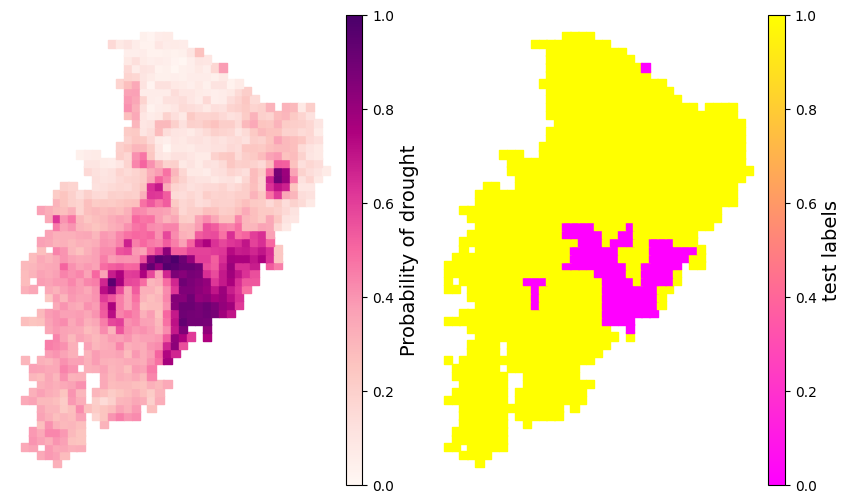

In [ ]:
# 0 = drought
# 1 = no drought
# produce maps of comparisons of probability of drought stress versus test_labels

fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(x_data_single['longitude'].to_numpy(), x_data_single['latitude'].to_numpy(), c=x_data_single['predictions_0'].to_numpy(), transform=ccrs.PlateCarree(),marker=',', cmap='RdPu',vmin=0,vmax=1)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
cbar.ax.set_ylabel('Probability of drought',fontsize='14')
#ax1.title.set_text('January 2018')
#ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax1.add_feature(shape_feature)
ax1.axis('off')

ax1 = fig.add_subplot(1,2,2,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(x_data_single['longitude'].to_numpy(), x_data_single['latitude'].to_numpy(),c= x_data_single['test_labels'].to_numpy(),marker=',', transform=ccrs.PlateCarree(), cmap='spring',vmin=0,vmax=1)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
cbar.ax.set_ylabel('test labels',fontsize='14')
#ax1.title.set_text('soybean harvested area')
#ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax1.add_feature(shape_feature)
ax1.axis('off')

#plt.title('January 2018')


plt.show()

In [ ]:
x_data_single_2 = x_data.loc[(x_data['year'] == 2018) & (x_data['month'] == 2)]

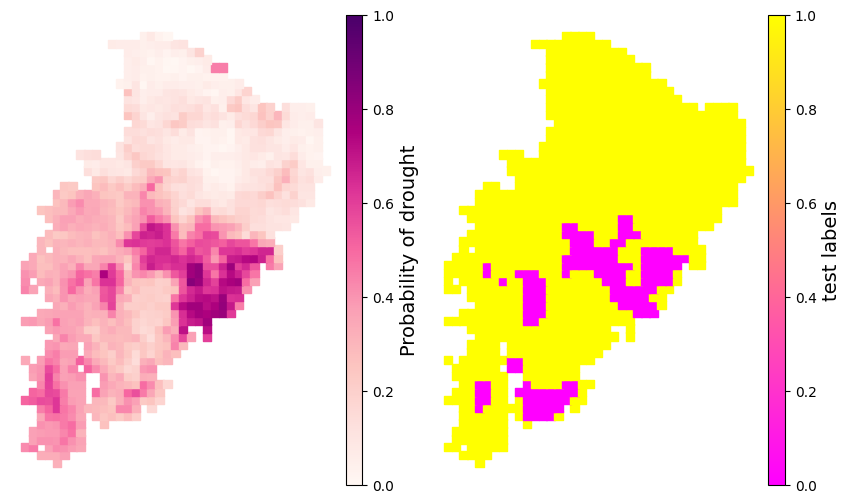

In [ ]:
# 0 = drought
# 1 = no drought
# produce maps of comparisons of probability of drought stress versus test_labels

fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(x_data_single_2['longitude'].to_numpy(), x_data_single_2['latitude'].to_numpy(), c=x_data_single_2['predictions_0'].to_numpy(), transform=ccrs.PlateCarree(),marker=',', cmap='RdPu',vmin=0,vmax=1)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
cbar.ax.set_ylabel('Probability of drought',fontsize='14')
#ax1.title.set_text('January 2018')
#ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax1.add_feature(shape_feature)
ax1.axis('off')

ax1 = fig.add_subplot(1,2,2,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(x_data_single_2['longitude'].to_numpy(), x_data_single_2['latitude'].to_numpy(),c= x_data_single_2['test_labels'].to_numpy(),marker=',', transform=ccrs.PlateCarree(), cmap='spring',vmin=0,vmax=1)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
cbar.ax.set_ylabel('test labels',fontsize='14')
#ax1.title.set_text('soybean harvested area')
#ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax1.add_feature(shape_feature)
ax1.axis('off')

#plt.title('January 2018')


plt.show()

In [ ]:
x_data_single_3 = x_data.loc[(x_data['year'] == 2018) & (x_data['month'] == 3)]

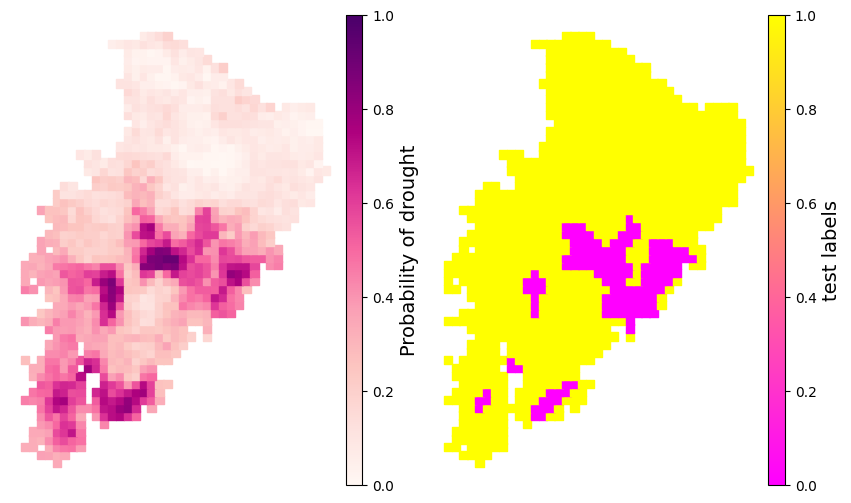

In [ ]:
# 0 = drought
# 1 = no drought
# produce maps of comparisons of probability of drought stress versus test_labels

fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(x_data_single_3['longitude'].to_numpy(), x_data_single_3['latitude'].to_numpy(), c=x_data_single_3['predictions_0'].to_numpy(), transform=ccrs.PlateCarree(),marker=',', cmap='RdPu',vmin=0,vmax=1)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
cbar.ax.set_ylabel('Probability of drought',fontsize='14')
#ax1.title.set_text('January 2018')
#ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax1.add_feature(shape_feature)
ax1.axis('off')

ax1 = fig.add_subplot(1,2,2,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(x_data_single_3['longitude'].to_numpy(), x_data_single_3['latitude'].to_numpy(),c= x_data_single_3['test_labels'].to_numpy(),marker=',', transform=ccrs.PlateCarree(), cmap='spring',vmin=0,vmax=1)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
cbar.ax.set_ylabel('test labels',fontsize='14')
#ax1.title.set_text('soybean harvested area')
#ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax1.add_feature(shape_feature)
ax1.axis('off')

#plt.title('January 2018')


plt.show()

In [ ]:
# plot confusion matrix of probability model predictions
print(predictions.shape)
print(np.argmax(predictions,axis=1).shape)

(53110, 2)
(53110,)


In [ ]:
# value predicted as most likely
val = np.argmax(predictions,axis=1)

[[0.30564865 0.07514592]
 [0.14306157 0.47614385]]


Text(50.722222222222214, 0.5, 'true')

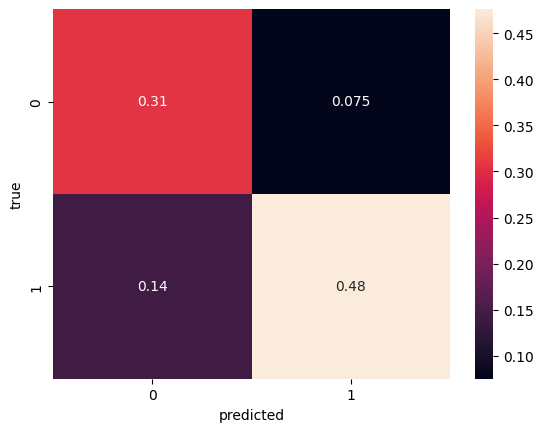

In [ ]:
#
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, val,normalize='all')
print(cm)
#plot
import seaborn as sns
sns.heatmap(cm, annot=True)
plt.xlabel('predicted')
plt.ylabel('true')

In [ ]:
# plot abundance of 2 classes
from collections import Counter
print(Counter(test_labels))
#
print(Counter(train_labels))

Counter({np.int64(1): 32886, np.int64(0): 20224})
Counter({np.int64(0): 101663, np.int64(1): 100607})


In [ ]:
# boxplot of class labels versus probability of drought impacts
#
print(x_data)

        longitude  latitude        VHI  year  month      precip  rtzsm_inst  \
179       -43.625   -16.375  49.550081  2018      1  101.785866    7.856639   
180       -43.625   -16.375  55.758888  2018      2  185.649930   64.927500   
181       -43.625   -16.375  55.967001  2018      3   91.033610   33.082700   
182       -43.625   -16.375  56.261465  2018      4   38.368736    5.066605   
183       -43.625   -16.375  55.017148  2018      5    0.453407    8.241758   
...           ...       ...        ...   ...    ...         ...         ...   
256504    -40.125    -2.875  47.687943  2021      7   14.897347   31.113653   
256505    -40.125    -2.875  55.700974  2021      8    0.000000   40.514210   
256506    -40.125    -2.875  57.413235  2021      9    0.000000   29.374584   
256507    -40.125    -2.875  64.088588  2021     10    0.000000   53.669280   
256508    -40.125    -2.875  60.751643  2021     11    7.135414   88.954250   

          msdwlwrf         t2m       pev  spei_30_d

In [ ]:
# prompt: find the maximum value from predictions 0 and predictions 1 per row and create new column with 0 for if predictions_0 is greater or 1 if predictions_1 is greater

# Assuming x_data is already defined as in your provided code.

x_data['max_prediction'] = x_data.apply(lambda row: max(row['predictions_0'], row['predictions_1']), axis=1)
x_data['predicted_class'] = x_data.apply(lambda row: 0 if row['predictions_0'] > row['predictions_1'] else 1, axis=1)
x_data


,longitude,latitude,VHI,year,month,precip,rtzsm_inst,msdwlwrf,t2m,pev,spei_30_days,spei_60_days,spei_90_days,y_test,predictions_0,predictions_1,test_labels,max_prediction,predicted_class
179,-43.625,-16.375,49.550081,2018,1,101.785866,7.856639,384.889698,299.002544,-0.006711,-0.815901,-0.606290,-0.804538,55.758888,0.32,0.68,1,0.68,1
180,-43.625,-16.375,55.758888,2018,2,185.649930,64.927500,390.653222,297.598506,-0.005182,1.015314,0.221063,0.258864,55.967001,0.32,0.68,1,0.68,1
181,-43.625,-16.375,55.967001,2018,3,91.033610,33.082700,389.514020,297.962570,-0.005195,0.147350,0.822355,0.297948,56.261465,0.34,0.66,1,0.66,1
182,-43.625,-16.375,56.261465,2018,4,38.368736,5.066605,381.664362,296.693852,-0.004671,-0.177661,-0.057841,0.643364,55.017148,0.16,0.84,1,0.84,1
183,-43.625,-16.375,55.017148,2018,5,0.453407,8.241758,365.041448,295.806026,-0.004585,-0.056589,-0.148727,-0.061229,54.199551,0.19,0.81,1,0.81,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256504,-40.125,-2.875,47.687943,2021,7,14.897347,31.113653,409.414234,300.809106,-0.006142,0.019459,-0.357286,-0.105382,55.700974,0.11,0.89,1,0.89,1
256505,-40.125,-2.875,55.700974,2021,8,0.000000,40.514210,403.381816,301.255260,-0.007461,0.425891,0.079931,-0.275009,57.413235,0.10,0.90,1,0.90,1
256506,-40.125,-2.875,57.413235,2021,9,0.000000,29.374584,405.351046,301.555438,-0.007663,-0.268102,0.205024,0.079390,64.088588,0.06,0.94,1,0.94,1
256507,-40.125,-2.875,64.088588,2021,10,0.000000,53.669280,411.521164,301.653660,-0.007142,0.838151,0.368097,0.520102,60.751643,0.08,0.92,1,0.92,1


In [ ]:
# prompt: find precision between predicted_class and test_labels for each lon and lat pair

import pandas as pd
# Assuming x_data is already defined as in your provided code.

# ... (your existing code) ...

# Calculate precision for each lon/lat pair
precision_results = {}
for (lon, lat), group_data in x_data.groupby(['longitude', 'latitude']):
    predicted_class = group_data['predicted_class'].values
    test_labels = group_data['test_labels'].values

    cm = confusion_matrix(test_labels, predicted_class)

    if cm.shape == (2, 2):
        true_positives = cm[1, 1]
        false_positives = cm[0, 1]
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    else:
        precision = 0  # Handle cases with only one class

    precision_results[(lon, lat)] = precision

precision_df = pd.DataFrame.from_dict(precision_results, orient='index', columns=['precision'])

precision_df


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use th

,precision
"(-44.625, -15.875)",0.857143
"(-44.625, -14.375)",0.884615
"(-44.625, -13.125)",0.968750
"(-44.625, -11.875)",0.846154
"(-44.625, -10.875)",0.920000
...,...
"(-35.375, -6.375)",0.812500
"(-35.375, -6.125)",0.818182
"(-35.375, -5.875)",0.833333
"(-35.375, -5.625)",0.842105


In [ ]:
# prompt: find recall between predicted_class and test_labels for each lon and lat pair

import pandas as pd
# Assuming x_data is already defined as in your provided code.

# ... (your existing code) ...

# Calculate recall for each lon/lat pair
recall_results = {}
for (lon, lat), group_data in x_data.groupby(['longitude', 'latitude']):
    predicted_class = group_data['predicted_class'].values
    test_labels = group_data['test_labels'].values

    cm = confusion_matrix(test_labels, predicted_class)

    if cm.shape == (2, 2):
        true_positives = cm[1, 1]
        false_negatives = cm[1, 0]
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    else:
        recall = 0 # Handle cases with only one class

    recall_results[(lon, lat)] = recall

recall_df = pd.DataFrame.from_dict(recall_results, orient='index', columns=['recall'])

recall_df


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use th

,recall
"(-44.625, -15.875)",0.666667
"(-44.625, -14.375)",0.696970
"(-44.625, -13.125)",0.688889
"(-44.625, -11.875)",0.785714
"(-44.625, -10.875)",0.676471
...,...
"(-35.375, -6.375)",0.866667
"(-35.375, -6.125)",0.870968
"(-35.375, -5.875)",0.882353
"(-35.375, -5.625)",0.914286


In [ ]:
# prompt: convert index to list

# Assuming x_data is already defined as in your provided code.
index_list = list(recall_df.index)
print(type(index_list[0]))


<class 'tuple'>


In [ ]:
print(index_list[0])

(np.float64(-44.625), np.float64(-15.875))


In [ ]:
# prompt: split list of tuples into 2 separate lists
def split_tuple_list(tuple_list):
    lon_list = [item[0] for item in tuple_list]
    lat_list = [item[1] for item in tuple_list]
    return lon_list, lat_list

In [ ]:
lon_list, lat_list = split_tuple_list(index_list)

In [ ]:
print(lon_list)

[np.float64(-44.625), np.float64(-44.625), np.float64(-44.625), np.float64(-44.625), np.float64(-44.625), np.float64(-44.625), np.float64(-44.625), np.float64(-44.625), np.float64(-44.375), np.float64(-44.375), np.float64(-44.375), np.float64(-44.375), np.float64(-44.375), np.float64(-44.375), np.float64(-44.375), np.float64(-44.375), np.float64(-44.375), np.float64(-44.375), np.float64(-44.375), np.float64(-44.375), np.float64(-44.125), np.float64(-44.125), np.float64(-44.125), np.float64(-44.125), np.float64(-44.125), np.float64(-44.125), np.float64(-44.125), np.float64(-44.125), np.float64(-44.125), np.float64(-44.125), np.float64(-44.125), np.float64(-44.125), np.float64(-44.125), np.float64(-44.125), np.float64(-44.125), np.float64(-44.125), np.float64(-44.125), np.float64(-44.125), np.float64(-44.125), np.float64(-44.125), np.float64(-44.125), np.float64(-43.875), np.float64(-43.875), np.float64(-43.875), np.float64(-43.875), np.float64(-43.875), np.float64(-43.875), np.float64(-

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


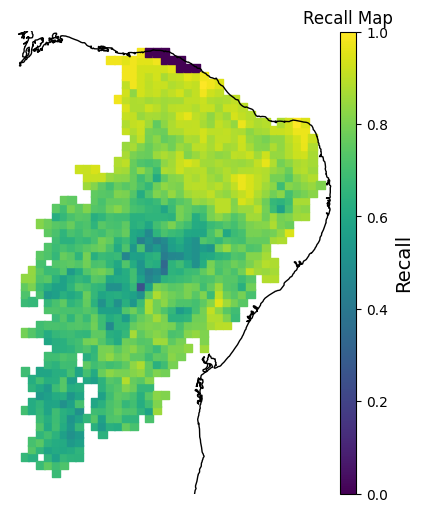

In [ ]:
# prompt: map of recall using lon_list and lat_list

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot the recall values on the map
im = ax.scatter(lon_list, lat_list, c=recall_df['recall'], transform=ccrs.PlateCarree(), marker=',', cmap='viridis', vmin=0, vmax=1)

# Add a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax, cax=cax)
cbar.ax.set_ylabel('Recall', fontsize='14')

# Set map extent (optional, adjust as needed)
#ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())

# Add coastlines (optional)
ax.coastlines()

ax.axis('off')
plt.title('Recall Map')
plt.show()


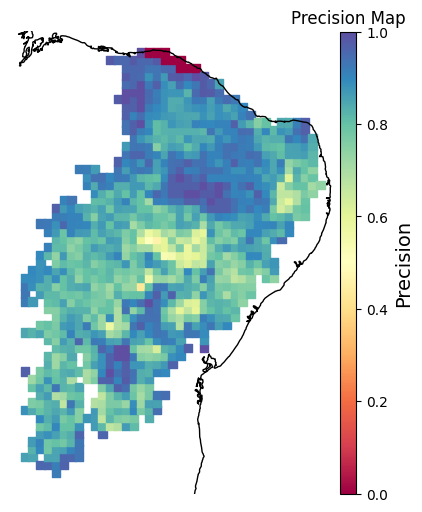

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot the recall values on the map
im = ax.scatter(lon_list, lat_list, c=precision_df['precision'], transform=ccrs.PlateCarree(), marker=',', cmap='Spectral', vmin=0, vmax=1)

# Add a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax, cax=cax)
cbar.ax.set_ylabel('Precision', fontsize='14')

# Set map extent (optional, adjust as needed)
#ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())

# Add coastlines (optional)
ax.coastlines()

ax.axis('off')
plt.title('Precision Map')
plt.show()


In [ ]:
x_test2 = x_test.copy()
x_test2['predictions_0'] = predictions[:,0]
x_test2['predictions_1'] = predictions[:,1]
x_test2['test_labels'] = x_data['test_labels']

In [ ]:
# argmax to get maximum between predictons_0 and predictions_1
predictions_val = x_test2[['predictions_0','predictions_1']].idxmax(axis=1)
#print(predictions_val)
print(predictions_val.unique())
predictions_val_list=[]
for i in range(len(predictions_val)):
  if predictions_val.values[i] == 'predictions_0':
    predictions_val_list.append(0)
  else:
    predictions_val_list.append(1)
#print(predictions_val)
x_test2['predictions_val'] = predictions_val_list
x_test2['predictions_val'].unique()

['predictions_1' 'predictions_0']


array([1, 0])

In [ ]:
# Get map of accuracy
# filter into lon + lat lists using groupby
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
coords_accuracy=[]
coords_recall=[]
coords_precision=[]
coords_f1=[]
lat_list=[]
lon_list=[]
for ind,df in x_test2.groupby(['latitude','longitude']):
  # compute accuracy for each df
  print(df['predictions_val'].unique())
  print(df['test_labels'].unique())
  print(df['test_labels'].values)
  print(df['predictions_val'].values)
  print(type(df['predictions_val'].values))
  coords_accuracy_ind = accuracy_score(df['test_labels'].values,df['predictions_val'].values)
  coords_accuracy.append(coords_accuracy_ind)
  # compute recall and precision
  recall_i = recall_score(df['test_labels'],df['predictions_val'])
  precision_i = precision_score(df['test_labels'],df['predictions_val'])
  # compute f1 score
  f1_i = f1_score(df['test_labels'],df['predictions_val'])
  coords_recall.append(recall_i)
  coords_precision.append(precision_i)
  coords_f1.append(f1_i)
  # append coordinates to list
  print(df['latitude'].values[0])
  print(df['longitude'].values[0])
  lat_list.append(df['latitude'].values[0])
  lon_list.append(df['longitude'].values[0])


print(coords_accuracy)
print(coords_recall)
print(coords_precision)
print(coords_f1)


Streaming output truncated to the last 5000 lines.
-40.875
[1 0]
[0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 1]
[1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1
 0 0 0 0 0 0 0 0 0 0]
<class 'numpy.ndarray'>
-8.875
-40.625
[1 0]
[0 1]
[0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 1]
[1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0
 0 1 0 0 0 0 0 0 0 0]
<class 'numpy.ndarray'>
-8.875
-40.375
[1 0]
[0 1]
[0 1 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 1]
[1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0
 0 1 0 0 0 0 0 0 0 0]
<class 'numpy.ndarray'>
-8.875
-40.125
[1 0]
[1 0]
[1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 1]
[1 1 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 0 0]


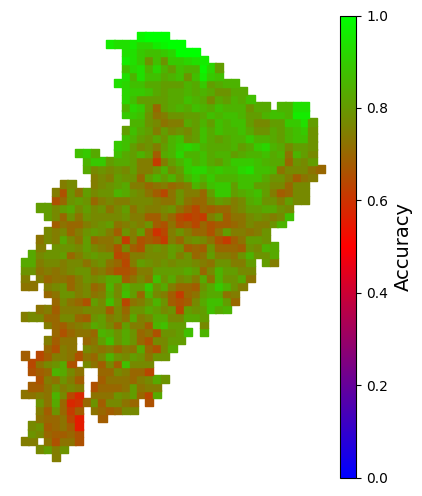

In [ ]:
# map of accuracy for Pampa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot the recall values on the map
im = ax.scatter(lon_list, lat_list, c=coords_accuracy, transform=ccrs.PlateCarree(), marker=',', cmap='brg', vmin=0, vmax=1)

# Add a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax, cax=cax)
cbar.ax.set_ylabel('Accuracy', fontsize='14')

# Set map extent (optional, adjust as needed)
#ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())

# Add coastlines (optional)
#ax.coastlines()
#pampa_df.plot()
ax.axis('off')
#plt.title('Precision Map')
plt.show()


In [ ]:
# create dataframe from lat_list, lon_list and coords_accuracy
df_accuracy = pd.DataFrame({'lat': lat_list, 'lon': lon_list, 'accuracy': coords_accuracy})
# save dataframe as csv
df_accuracy.to_csv('/content/drive/MyDrive/rs_data/biomes_data/accuracy_caatinga.csv', index=False)

# df_precision
df_precision = pd.DataFrame({'lat': lat_list, 'lon': lon_list, 'precision': coords_precision})
#save dataframe to csv
df_precision.to_csv('/content/drive/MyDrive/rs_data/biomes_data/precision_caatinga.csv', index=False)

# df_recall
df_recall = pd.DataFrame({'lat': lat_list, 'lon': lon_list, 'recall': coords_recall})
#save dataframe to csv
df_recall.to_csv('/content/drive/MyDrive/rs_data/biomes_data/recall_caatinga.csv', index=False)

# df_f1
df_f1 = pd.DataFrame({'lat': lat_list, 'lon': lon_list, 'f1': coords_f1})
#save dataframe to csv
df_f1.to_csv('/content/drive/MyDrive/rs_data/biomes_data/f1_caatinga.csv', index=False)



In [ ]:
print(x_data)

        longitude  latitude        VHI  year  month      precip  rtzsm_inst  \
179       -43.625   -16.375  49.550081  2018      1  101.785866    7.856639   
180       -43.625   -16.375  55.758888  2018      2  185.649930   64.927500   
181       -43.625   -16.375  55.967001  2018      3   91.033610   33.082700   
182       -43.625   -16.375  56.261465  2018      4   38.368736    5.066605   
183       -43.625   -16.375  55.017148  2018      5    0.453407    8.241758   
...           ...       ...        ...   ...    ...         ...         ...   
256504    -40.125    -2.875  47.687943  2021      7   14.897347   31.113653   
256505    -40.125    -2.875  55.700974  2021      8    0.000000   40.514210   
256506    -40.125    -2.875  57.413235  2021      9    0.000000   29.374584   
256507    -40.125    -2.875  64.088588  2021     10    0.000000   53.669280   
256508    -40.125    -2.875  60.751643  2021     11    7.135414   88.954250   

          msdwlwrf         t2m       pev  spei_30_d

In [ ]:
# groupby month
def group_df_month(df):
  # append grouped dfs into list
  df_list = []
  # group by lat and lon
  df_grouped = df.groupby(['month'])
  # append each group to list
  for group in df_grouped:
    df_list.append(group)
  return df_list


grouped_df = group_df_month(x_data)


# get accuracy per month
accuracy_list = []
recall_list = []
precision_list = []
for i in range(len(grouped_df)):
  print(grouped_df[i][1])
  accuracy_list.append(accuracy_score(grouped_df[i][1]['test_labels'],grouped_df[i][1]['predicted_class']))
  recall_list.append(recall_score(grouped_df[i][1]['test_labels'],grouped_df[i][1]['predicted_class']))
  precision_list.append(precision_score(grouped_df[i][1]['test_labels'],grouped_df[i][1]['predicted_class']))
  #print(accuracy_score(grouped_df[i][1]['test_labels'],grouped_df[i][1]['predicted_class']))
  #print(recall_score(grouped_df[i[1]]['test_labels'],grouped_df[i][1]['predicted_class']))


        longitude  latitude        VHI  year  month      precip  rtzsm_inst  \
179       -43.625   -16.375  49.550081  2018      1  101.785866    7.856639   
191       -43.625   -16.375  28.666348  2019      1   30.289810    6.283073   
203       -43.625   -16.375  42.189026  2020      1  304.319270   35.624756   
215       -43.625   -16.375  46.483570  2021      1   54.926197    5.313969   
406       -44.125   -16.125  46.984668  2018      1   94.008120    5.495644   
...           ...       ...        ...   ...    ...         ...         ...   
256271    -40.375    -2.875  46.091292  2021      1   69.721950   31.514551   
256462    -40.125    -2.875  54.405240  2018      1  177.192550   29.246729   
256474    -40.125    -2.875  55.754870  2019      1  119.757290   77.454346   
256486    -40.125    -2.875  68.110767  2020      1  165.798220   73.506970   
256498    -40.125    -2.875  47.561257  2021      1   73.456375   18.528835   

          msdwlwrf         t2m       pev  spei_30_d

In [ ]:
print(accuracy_list)
print(recall_list)
print(precision_list)
month_list = [1,2,3,4,5,6,7,8,9,10,11,12]

[0.7685840707964602, 0.7460176991150442, 0.8668141592920354, 0.8632743362831858, 0.8106194690265487, 0.859070796460177, 0.7597345132743363, 0.8606194690265486, 0.7856194690265487, 0.7015486725663717, 0.7061946902654868, 0.640117994100295]
[0.7200126262626263, 0.7209179635979952, 0.876773711725168, 0.9673971138428648, 0.9925900976759852, 0.9701675521046179, 0.6965765765765766, 0.832944470368642, 0.5896596858638743, 0.35235602094240837, 0.5792474344355758, 0.7042492917847025]
[0.9348360655737705, 0.9681190223166843, 0.9705152934692752, 0.8794946550048591, 0.7794234329542449, 0.8080326752893124, 0.8879191548001837, 0.8677685950413223, 0.7248592115848753, 0.8573248407643312, 0.873352435530086, 0.6403915507470376]


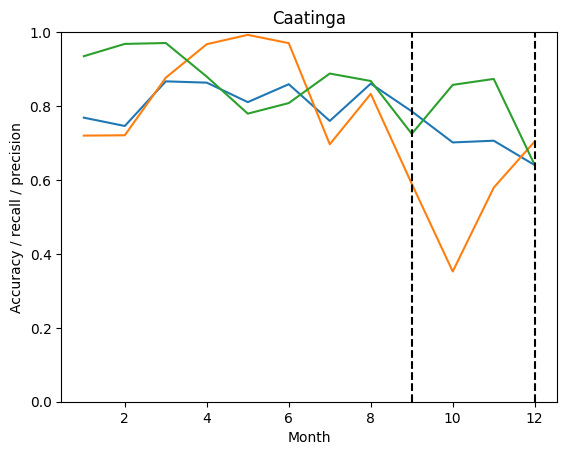

In [ ]:
# plot accuracy_list
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(month_list,accuracy_list)
plt.plot(month_list,recall_list)
plt.plot(month_list,precision_list)
plt.plot([9,9],[0,1],'k--')
plt.plot([12,12],[0,1],'k--')
plt.xlabel('Month')
plt.ylabel('Accuracy / recall / precision')
plt.title('Caatinga')
plt.ylim(0,1)
#plt.legend(['accuracy','recall','precision'])
plt.savefig('/content/drive/MyDrive/Figures/cssp_paper2/monthly_accuracy_recall_precision_caatinga.png',dpi=300)
plt.show()

In [ ]:
# prompt: find the sum of test_labels for each month

import pandas as pd

# Assuming x_data is your DataFrame
# ... (your existing code to define x_data)

# Group data by year and month, then sum 'test_labels' for each group
monthly_sums = x_data.groupby(['month'])['test_labels'].sum()

monthly_sums


,test_labels
month,
1,3168
2,3791
3,4017
4,3742
5,2969
6,2447
7,2775
8,2143
9,1528


In [ ]:
print(np.sum(monthly_sums))

32886


In [ ]:
# calculate monthly sums as a percentage of total
monthly_sums_percentage = monthly_sums / np.sum(monthly_sums) * 100

monthly_sums_percentage

,test_labels
month,
1,9.633279
2,11.527702
3,12.214924
4,11.378702
5,9.028158
6,7.440856
7,8.438241
8,6.516451
9,4.646354


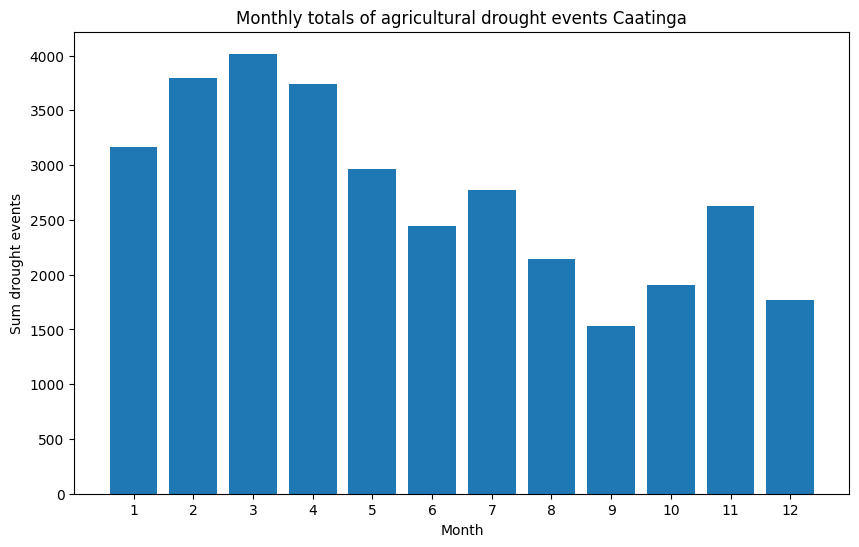

In [ ]:
# prompt: plot monthly_sums as bar plot

import matplotlib.pyplot as plt

# Assuming monthly_sums is already defined as in your provided code.

# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(monthly_sums.index, monthly_sums.values)
plt.xlabel("Month")
plt.ylabel("Sum drought events")
plt.title("Monthly totals of agricultural drought events Caatinga")
plt.xticks(monthly_sums.index)  # Ensure all months are displayed on the x-axis
#plt.grid(axis='y', linestyle='--') # Add a grid for better readability
plt.show()


In [ ]:
monthly_average_probabilities = x_data.groupby(['month'])['predictions_0'].mean()

monthly_average_probabilities

,predictions_0
month,
1,0.476192
2,0.410018
3,0.295706
4,0.203283
5,0.240608
6,0.387436
7,0.511504
8,0.539248
9,0.642562


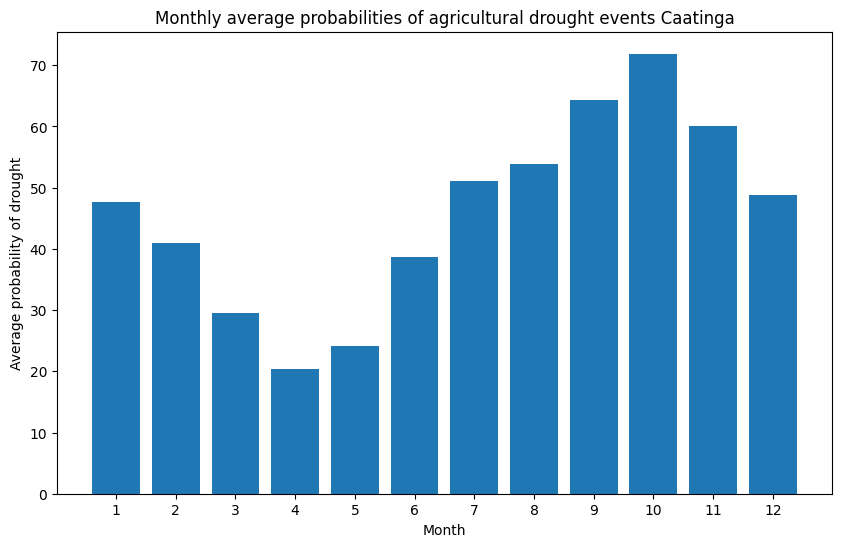

In [ ]:
# prompt: plot monthly average probabilities

import matplotlib.pyplot as plt
# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(monthly_average_probabilities.index, monthly_average_probabilities.values*100)
plt.xlabel("Month")
plt.ylabel("Average probability of drought")
plt.title("Monthly average probabilities of agricultural drought events Caatinga")
plt.xticks(monthly_average_probabilities.index)  # Ensure all months are displayed on the x-axis
#plt.grid(axis='y', linestyle='--') # Add a grid for better readability
plt.show()


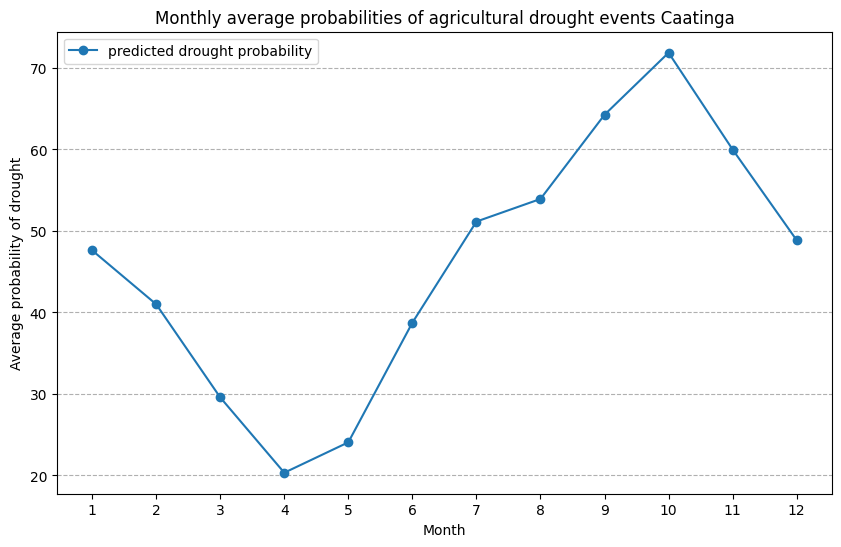

In [ ]:
# prompt: line plot of monthly average probabilities

import matplotlib.pyplot as plt
# Assuming monthly_average_probabilities is already defined as in your provided code.

# Create the line plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(monthly_average_probabilities.index, monthly_average_probabilities.values*100, marker='o', linestyle='-',label='predicted drought probability')
#plt.plot(monthly_average_probabilities.index, monthly_sums_percentage.values, marker='o', linestyle='-',label='observed drought probability')
plt.xlabel("Month")
plt.ylabel("Average probability of drought")
plt.legend()
plt.title("Monthly average probabilities of agricultural drought events Caatinga")
plt.xticks(monthly_average_probabilities.index)  # Ensure all months are displayed on the x-axis
plt.grid(axis='y', linestyle='--') # Add a grid for better readability
plt.show()


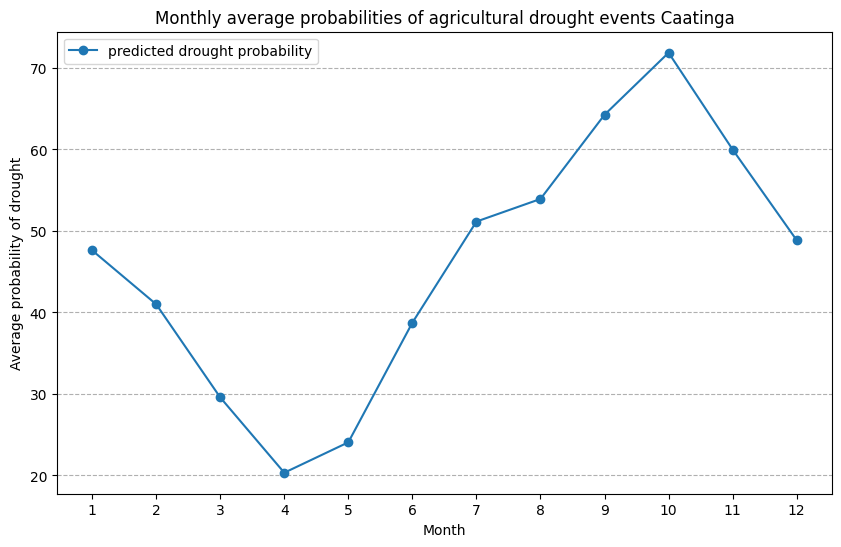

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(monthly_average_probabilities.index, monthly_average_probabilities.values*100, marker='o', linestyle='-',label='predicted drought probability')
#plt.plot(monthly_average_probabilities.index, monthly_sums_percentage.values, marker='o', linestyle='-',label='observed drought probability')
plt.xlabel("Month")
plt.ylabel("Average probability of drought")
#add second axes with bar chart
plt.legend()
plt.title("Monthly average probabilities of agricultural drought events Caatinga")
plt.xticks(monthly_average_probabilities.index)  # Ensure all months are displayed on the x-axis
plt.grid(axis='y', linestyle='--') # Add a grid for better readability
plt.show()

In [ ]:
def save_pickle(f_name,obj):
  with open(f_name, 'wb') as f:
    pickle.dump(obj, f)

#save monthly average probabilities as pickle file
save_pickle('/content/drive/MyDrive/monthly_average_probabilities_caatinga.pkl',monthly_average_probabilities)

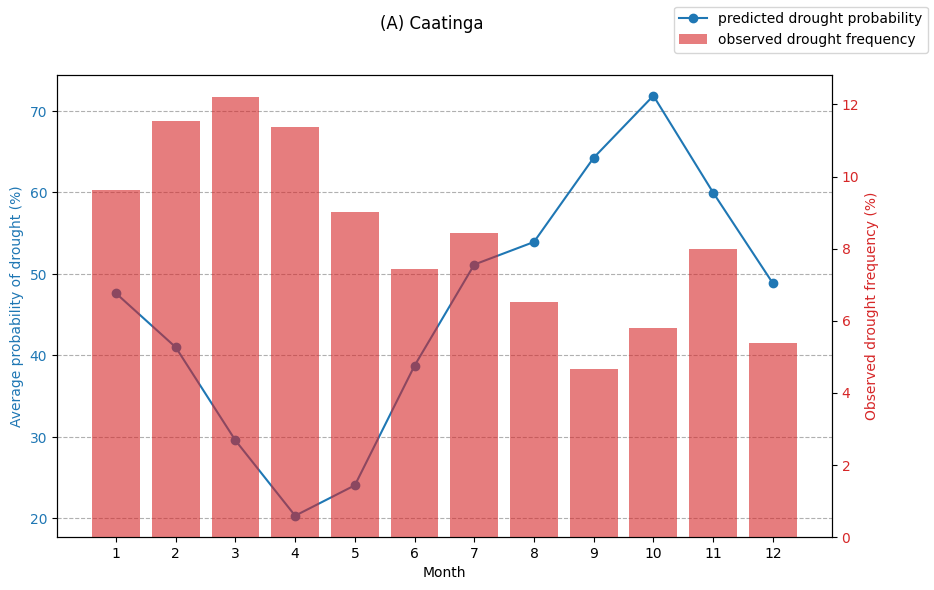

In [ ]:
# prompt: make Figure with 2 y axes

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(monthly_average_probabilities.index, monthly_average_probabilities.values*100, marker='o', linestyle='-', label='predicted drought probability', color='tab:blue')
ax1.set_xlabel("Month")
ax1.set_ylabel("Average probability of drought (%)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(monthly_average_probabilities.index)
ax1.grid(axis='y', linestyle='--')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.bar(monthly_sums_percentage.index, monthly_sums_percentage.values, color='tab:red', alpha=0.6, label='observed drought frequency')
ax2.set_ylabel("Observed drought frequency (%)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')


fig.suptitle("(A) Caatinga")
fig.legend(loc="upper right")
plt.show()


In [ ]:
yearly_average_probabilities = x_data.groupby(['year'])['predictions_0'].mean()

yearly_average_probabilities

,predictions_0
year,
2018,0.480823
2019,0.524094
2020,0.300462
2021,0.536558


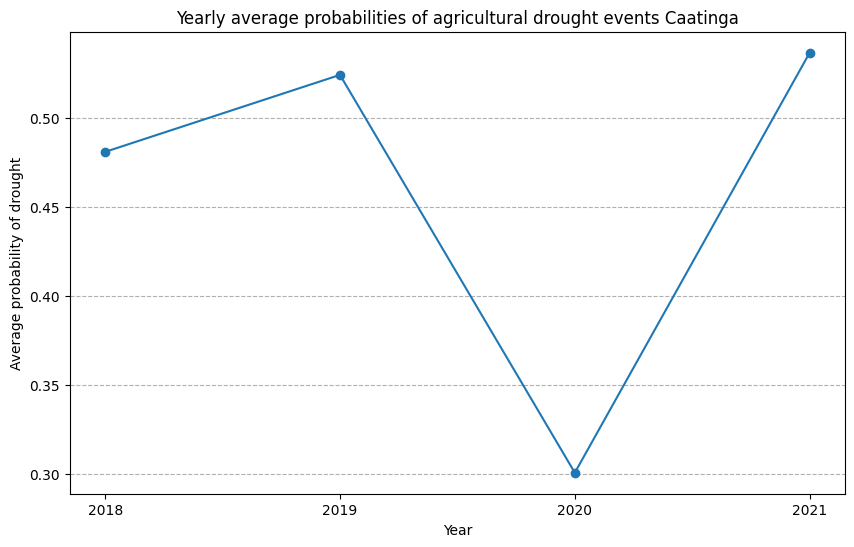

In [ ]:
# prompt: plot yearly average probabilities

import matplotlib.pyplot as plt
# Create the line plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(yearly_average_probabilities.index, yearly_average_probabilities.values, marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Average probability of drought")
plt.title("Yearly average probabilities of agricultural drought events Caatinga")
plt.xticks(yearly_average_probabilities.index)  # Ensure all years are displayed on the x-axis
plt.grid(axis='y', linestyle='--') # Add a grid for better readability
plt.show()


In [ ]:
areal_average_probabilities = x_data.groupby(['latitude','longitude'])['predictions_0'].mean()

areal_average_probabilities

latitude  longitude
-16.375   -43.625      0.536809
-16.125   -44.125      0.557872
          -43.875      0.580213
          -43.625      0.552128
          -43.375      0.489149
                         ...   
-3.125    -39.625      0.113617
-2.875    -40.875      0.136809
          -40.625      0.125957
          -40.375      0.120426
          -40.125      0.117872
Name: predictions_0, Length: 1130, dtype: float64

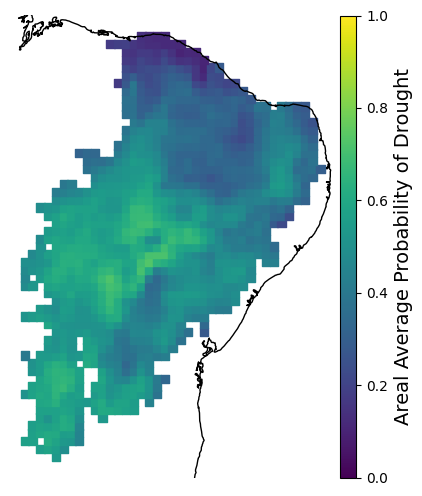

In [ ]:
# prompt: plot areal average probabilities

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming areal_average_probabilities is already defined as in your provided code.
index_list = list(areal_average_probabilities.index)
lon_list, lat_list = split_tuple_list(index_list)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot the areal average probabilities on the map
im = ax.scatter(lat_list, lon_list, c=areal_average_probabilities.values, transform=ccrs.PlateCarree(), marker=',', cmap='viridis', vmin=0, vmax=1)

# Add a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax, cax=cax)
cbar.ax.set_ylabel('Areal Average Probability of Drought', fontsize='14')

# Set map extent (optional, adjust as needed)
# ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())

# Add coastlines (optional)
ax.coastlines()

ax.axis('off')
#plt.title('Areal Average Probabilities Map')
plt.show()


In [ ]:
print(X_train)

        longitude  latitude        VHI  year  month     precip  rtzsm_inst  \
0         -43.625   -16.375  48.847092  2003      2  21.272581   15.995748   
1         -43.625   -16.375  38.437785  2003      3  57.438198   15.065541   
2         -43.625   -16.375  36.187071  2003      4  22.478333   27.119629   
3         -43.625   -16.375  33.244057  2003      5   2.128676   16.330154   
4         -43.625   -16.375  29.727946  2003      6   0.000000   19.214056   
...           ...       ...        ...   ...    ...        ...         ...   
256457    -40.125    -2.875  75.261785  2017      8   0.000000   27.014313   
256458    -40.125    -2.875  70.254602  2017      9   0.000000   12.248808   
256459    -40.125    -2.875  66.815062  2017     10   1.539913   33.085880   
256460    -40.125    -2.875  60.800818  2017     11   0.000000    1.974725   
256461    -40.125    -2.875  59.727618  2017     12  11.568439   31.772526   

          msdwlwrf         t2m       pev  spei_30_days  spei_60

In [ ]:
print(x_test)

        longitude  latitude        VHI  year  month      precip  rtzsm_inst  \
179       -43.625   -16.375  49.550081  2018      1  101.785866    7.856639   
180       -43.625   -16.375  55.758888  2018      2  185.649930   64.927500   
181       -43.625   -16.375  55.967001  2018      3   91.033610   33.082700   
182       -43.625   -16.375  56.261465  2018      4   38.368736    5.066605   
183       -43.625   -16.375  55.017148  2018      5    0.453407    8.241758   
...           ...       ...        ...   ...    ...         ...         ...   
256504    -40.125    -2.875  47.687943  2021      7   14.897347   31.113653   
256505    -40.125    -2.875  55.700974  2021      8    0.000000   40.514210   
256506    -40.125    -2.875  57.413235  2021      9    0.000000   29.374584   
256507    -40.125    -2.875  64.088588  2021     10    0.000000   53.669280   
256508    -40.125    -2.875  60.751643  2021     11    7.135414   88.954250   

          msdwlwrf         t2m       pev  spei_30_d

In [ ]:
average_xtest_coords = x_test.groupby(['latitude', 'longitude']).mean().reset_index()
print(average_xtest_coords)

      latitude  longitude        VHI         year     month      precip  \
0      -16.375    -43.625  44.717498  2019.468085  6.382979   69.815214   
1      -16.125    -44.125  43.201518  2019.468085  6.382979   75.835399   
2      -16.125    -43.875  42.198437  2019.468085  6.382979   70.807125   
3      -16.125    -43.625  43.033509  2019.468085  6.382979   66.502754   
4      -16.125    -43.375  47.604360  2019.468085  6.382979   64.513851   
...        ...        ...        ...          ...       ...         ...   
1125    -3.125    -39.625  56.004942  2019.468085  6.382979   81.180231   
1126    -2.875    -40.875  57.371689  2019.468085  6.382979  121.601372   
1127    -2.875    -40.625  56.898794  2019.468085  6.382979  115.667759   
1128    -2.875    -40.375  56.897851  2019.468085  6.382979  108.639340   
1129    -2.875    -40.125  56.233049  2019.468085  6.382979  120.282107   

      rtzsm_inst    msdwlwrf         t2m       pev  spei_30_days  \
0      23.212413  373.756700  2

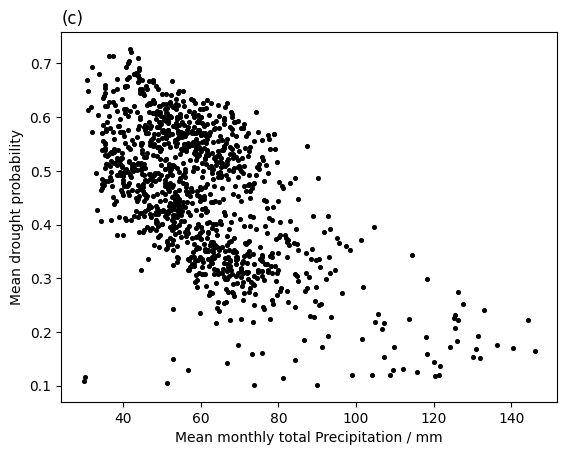

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(average_xtest_coords['precip'],average_xtest_coords['predictions_0'],s=7,c='k')
#
ax.set_ylabel('Mean drought probability')
ax.set_xlabel('Mean monthly total Precipitation / mm')
ax.set_title('(c)',loc='left')
plt.savefig('/content/drive/MyDrive/Figures/cssp_paper2/climate_prob_scatters/caatinga_rainfall_prob_scatter.png',dpi=300)
plt.show()

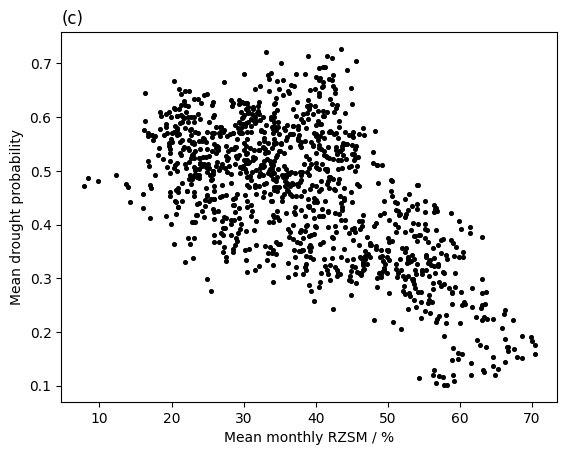

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(average_xtest_coords['rtzsm_inst'],average_xtest_coords['predictions_0'],s=7,c='k')
ax.set_ylabel('Mean drought probability')
ax.set_xlabel('Mean monthly RZSM / %')
ax.set_title('(c)',loc='left')
plt.savefig('/content/drive/MyDrive/Figures/cssp_paper2/climate_prob_scatters/caatinga_RZSM_prob_scatter.png',dpi=300)
plt.show()

In [ ]:
print(average_xtest_coords)

      latitude  longitude        VHI         year     month      precip  \
0      -16.375    -43.625  44.717498  2019.468085  6.382979   69.815214   
1      -16.125    -44.125  43.201518  2019.468085  6.382979   75.835399   
2      -16.125    -43.875  42.198437  2019.468085  6.382979   70.807125   
3      -16.125    -43.625  43.033509  2019.468085  6.382979   66.502754   
4      -16.125    -43.375  47.604360  2019.468085  6.382979   64.513851   
...        ...        ...        ...          ...       ...         ...   
1125    -3.125    -39.625  56.004942  2019.468085  6.382979   81.180231   
1126    -2.875    -40.875  57.371689  2019.468085  6.382979  121.601372   
1127    -2.875    -40.625  56.898794  2019.468085  6.382979  115.667759   
1128    -2.875    -40.375  56.897851  2019.468085  6.382979  108.639340   
1129    -2.875    -40.125  56.233049  2019.468085  6.382979  120.282107   

      rtzsm_inst    msdwlwrf         t2m       pev  spei_30_days  \
0      23.212413  373.756700  2

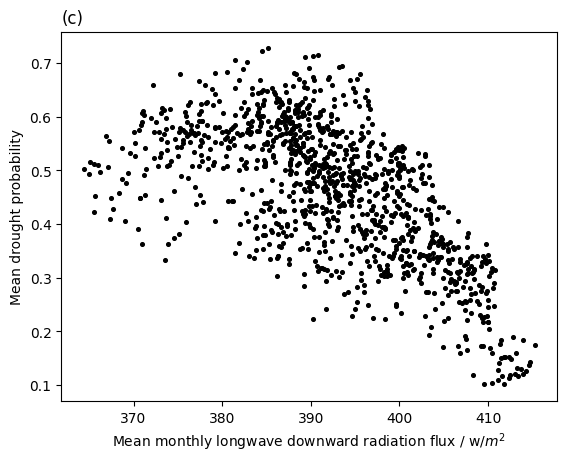

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(average_xtest_coords['msdwlwrf'],average_xtest_coords['predictions_0'],s=7,c='k')
ax.set_ylabel('Mean drought probability')
ax.set_xlabel(r'Mean monthly longwave downward radiation flux / w/$m^2$')
ax.set_title('(c)',loc='left')
plt.savefig('/content/drive/MyDrive/Figures/cssp_paper2/climate_prob_scatters/caatinga_srad_prob_scatter.png',dpi=300)
plt.show()

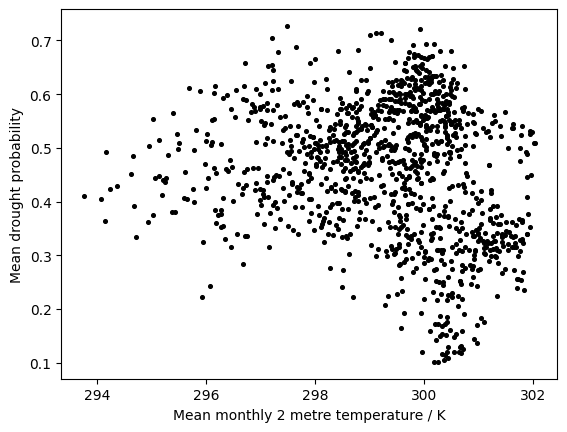

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(average_xtest_coords['t2m'],average_xtest_coords['predictions_0'],s=7,c='k')
ax.set_ylabel('Mean drought probability')
ax.set_xlabel(r'Mean monthly 2 metre temperature / K')
plt.show()

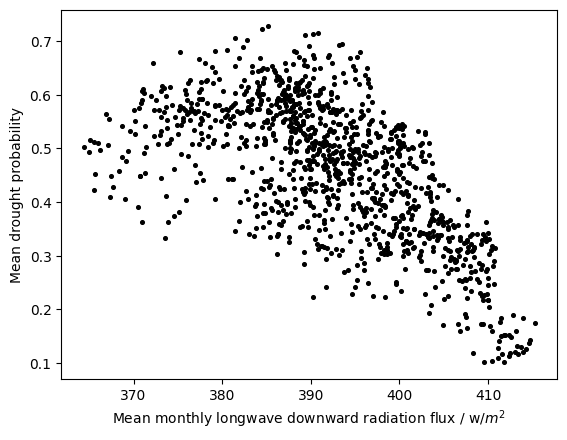

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(average_xtest_coords['msdwlwrf'],average_xtest_coords['predictions_0'],s=7,c='k')
ax.set_ylabel('Mean drought probability')
ax.set_xlabel(r'Mean monthly longwave downward radiation flux / w/$m^2$')
plt.show()

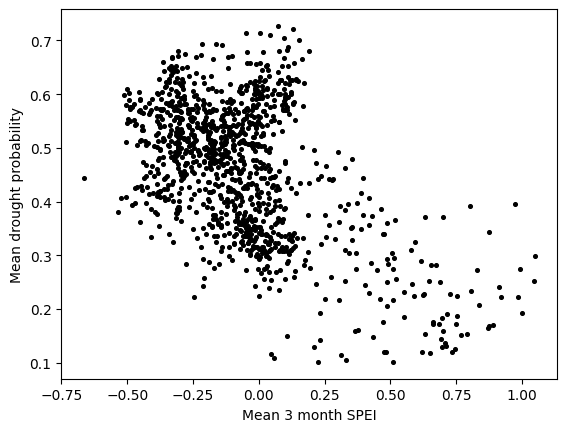

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(average_xtest_coords['spei_90_days'],average_xtest_coords['predictions_0'],s=7,c='k')
#
ax.set_ylabel('Mean drought probability')
ax.set_xlabel('Mean 3 month SPEI')
plt.show()

In [ ]:
print(x_test2)

        longitude  latitude        VHI  year  month      precip  rtzsm_inst  \
179       -43.625   -16.375  49.550081  2018      1  101.785866    7.856639   
180       -43.625   -16.375  55.758888  2018      2  185.649930   64.927500   
181       -43.625   -16.375  55.967001  2018      3   91.033610   33.082700   
182       -43.625   -16.375  56.261465  2018      4   38.368736    5.066605   
183       -43.625   -16.375  55.017148  2018      5    0.453407    8.241758   
...           ...       ...        ...   ...    ...         ...         ...   
256504    -40.125    -2.875  47.687943  2021      7   14.897347   31.113653   
256505    -40.125    -2.875  55.700974  2021      8    0.000000   40.514210   
256506    -40.125    -2.875  57.413235  2021      9    0.000000   29.374584   
256507    -40.125    -2.875  64.088588  2021     10    0.000000   53.669280   
256508    -40.125    -2.875  60.751643  2021     11    7.135414   88.954250   

          msdwlwrf         t2m       pev  spei_30_d

In [ ]:
# groupby month
def group_df_month(df):
  # append grouped dfs into list
  df_list = []
  # group by lat and lon
  df_grouped = df.groupby(['month'])
  # append each group to list
  for group in df_grouped:
    df_list.append(group)
  return df_list

In [ ]:
x_test2_monthly_list = group_df_month(x_test2)

In [ ]:
print(len(x_test2_monthly_list))

12


In [ ]:
def save_pickle(f_name,obj):
  with open(f_name, 'wb') as f:
    pickle.dump(obj, f)

#save monthly average probabilities as pickle file
save_pickle('/content/drive/MyDrive/average_testx_data/average_xtest_caatinga.pkl',average_xtest_coords)

In [ ]:
# Just do with Random forest model first as an example then switch to neural network
# X and y is same as above
X, y = X_train, train_labels

In [ ]:
print(X_train)

        longitude  latitude        VHI  year  month     precip  rtzsm_inst  \
0         -43.625   -16.375  48.847092  2003      2  21.272581   15.995748   
1         -43.625   -16.375  38.437785  2003      3  57.438198   15.065541   
2         -43.625   -16.375  36.187071  2003      4  22.478333   27.119629   
3         -43.625   -16.375  33.244057  2003      5   2.128676   16.330154   
4         -43.625   -16.375  29.727946  2003      6   0.000000   19.214056   
...           ...       ...        ...   ...    ...        ...         ...   
256457    -40.125    -2.875  75.261785  2017      8   0.000000   27.014313   
256458    -40.125    -2.875  70.254602  2017      9   0.000000   12.248808   
256459    -40.125    -2.875  66.815062  2017     10   1.539913   33.085880   
256460    -40.125    -2.875  60.800818  2017     11   0.000000    1.974725   
256461    -40.125    -2.875  59.727618  2017     12  11.568439   31.772526   

          msdwlwrf         t2m       pev  spei_30_days  spei_60

In [ ]:
print(X_train)

        longitude  latitude        VHI  year  month     precip  rtzsm_inst  \
0         -43.625   -16.375  48.847092  2003      2  21.272581   15.995748   
1         -43.625   -16.375  38.437785  2003      3  57.438198   15.065541   
2         -43.625   -16.375  36.187071  2003      4  22.478333   27.119629   
3         -43.625   -16.375  33.244057  2003      5   2.128676   16.330154   
4         -43.625   -16.375  29.727946  2003      6   0.000000   19.214056   
...           ...       ...        ...   ...    ...        ...         ...   
256457    -40.125    -2.875  75.261785  2017      8   0.000000   27.014313   
256458    -40.125    -2.875  70.254602  2017      9   0.000000   12.248808   
256459    -40.125    -2.875  66.815062  2017     10   1.539913   33.085880   
256460    -40.125    -2.875  60.800818  2017     11   0.000000    1.974725   
256461    -40.125    -2.875  59.727618  2017     12  11.568439   31.772526   

          msdwlwrf         t2m       pev  spei_30_days  spei_60

In [ ]:
feature_names = X_train.columns.tolist()
print(feature_names)

['longitude', 'latitude', 'VHI', 'year', 'month', 'precip', 'rtzsm_inst', 'msdwlwrf', 't2m', 'pev', 'spei_30_days', 'spei_60_days', 'spei_90_days']


In [ ]:
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X, y)

RandomForestClassifier(n_estimators=50, random_state=42)

In [ ]:
print(X)

        longitude  latitude        VHI  year  month     precip  rtzsm_inst  \
0         -43.625   -16.375  48.847092  2003      2  21.272581   15.995748   
1         -43.625   -16.375  38.437785  2003      3  57.438198   15.065541   
2         -43.625   -16.375  36.187071  2003      4  22.478333   27.119629   
3         -43.625   -16.375  33.244057  2003      5   2.128676   16.330154   
4         -43.625   -16.375  29.727946  2003      6   0.000000   19.214056   
...           ...       ...        ...   ...    ...        ...         ...   
256457    -40.125    -2.875  75.261785  2017      8   0.000000   27.014313   
256458    -40.125    -2.875  70.254602  2017      9   0.000000   12.248808   
256459    -40.125    -2.875  66.815062  2017     10   1.539913   33.085880   
256460    -40.125    -2.875  60.800818  2017     11   0.000000    1.974725   
256461    -40.125    -2.875  59.727618  2017     12  11.568439   31.772526   

          msdwlwrf         t2m       pev  spei_30_days  spei_60

In [ ]:
### Example code works so adapt to my drought dataset
# https://docs.seldon.io/projects/alibi/en/latest/examples/anchor_tabular_iris.html

In [ ]:
# Adapt example code to derive anchor rules for drought conditions in Caatinga
predict_fn = lambda x: clf.predict_proba(x)
print(predict_fn)

<function <lambda> at 0x7b5a935fcfe0>


In [ ]:
print(feature_names)

['longitude', 'latitude', 'VHI', 'year', 'month', 'precip', 'rtzsm_inst', 'msdwlwrf', 't2m', 'pev', 'spei_30_days', 'spei_60_days', 'spei_90_days']


In [ ]:
explainer = AnchorTabular(predict_fn, feature_names)

NameError: name 'AnchorTabular' is not defined

In [ ]:
print(X_train)

In [ ]:
np.random.seed(0)

In [ ]:
print(X_train.values)

In [ ]:
explainer.fit(X_train.values, disc_perc=(25, 50, 75))

In [ ]:
idx = 0
#print('Prediction: ', class_names[explainer.predictor(x_test[idx].reshape(1, -1))[0]])

In [ ]:
print(x_test.values[0])

In [ ]:
print(x_test)
test_labels = x_test['test_labels']
print(test_labels)
print(len(test_labels))

In [ ]:
# remove last 5 columns from x_test
x_test2 = x_test.iloc[:, :-6]
print(x_test2)

In [ ]:
idx=300
print(x_test2.values[idx])
print(test_labels.values[idx])
print(test_labels)
print(len(test_labels))
print(len(x_test2))

In [ ]:
#explanation = explainer.explain(x_test2.values[idx], threshold=0.95)
#print('Anchor: %s' % (' AND '.join(explanation.anchor)))
#print(f"Anchor: {explanation.anchor}")
#print('Precision: %.2f' % explanation.precision)
#print('Coverage: %.2f' % explanation.coverage)

In [ ]:
# explain all drought predictions
#list_of_anchors = []
#list_of_precisions = []
#list_of_coverages = []
#for i in range(len(x_test2)):
#  if test_labels.values[i] == 0:
#    explanation = explainer.explain(x_test2.values[i], threshold=0.95)
#    print('Anchor: %s' % (' AND '.join(explanation.anchor)))
#    list_of_anchors.append(explanation.anchor)
#    list_of_precisions.append(explanation.precision)
#    list_of_coverages.append(explanation.coverage)
#    print('Precision: %.2f' % explanation.precision)
#    print('Coverage: %.2f' % explanation.coverage)


In [ ]:
# find the anchor rule with the highest data set coverage
